In [4]:
import pandas as pd
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
sns.set('notebook')

def select_milk_features(milk):
    return milk[['animal_id','date','milk_weight']]

def append_cow_age_to_milk_dataframe(milk, birthdates):
    """ Adds a cows age in month for each day milked"""
    milk = milk.reset_index()
    milk = pd.merge(left=milk, right=birthdates, left_on='animal_id', right_on='animal_id')
    milk['months_aged'] = (milk_with_ages['date'] - milk_with_ages['birthdate']).astype('timedelta64[M]')
    return milk

def retrieve_data():
    engine =  create_engine('sqlite:///../data/database/happycows.db')
    with engine.connect() as con:
        milk = pd.read_sql_table('milk_volume', con)
        milk = select_milk_features(milk)
        birthdates = pd.read_sql_table('birthdates', con)
    return milk, birthdates

In [26]:
milk, birthdates = retrieve_data()
total_milk_weight = milk.set_index('date')['2016-01-01':'2017-12-31'].sort_index().sum()['milk_weight']
total_milk_weight

7828126.700000043

In [13]:
from datetime import datetime

def number_of_days_in_period(start, end):
    start = datetime.strptime(start, '%m-%d-%Y')
    end = datetime.strptime(end, '%m-%d-%Y')
    return (start - end).days

def build_performance_profiles_for_period(milk, birthdates, start='1-1-2016', end='12-31-2017'):
    period_milk = milk.set_index('date')[start:end]
    period_milk = pd.merge(left=period_milk, right=birthdates, left_on='animal_id', right_on='animal_id')
    
    days_in_period = number_of_days_in_period(start, end)
    
    profiles = []
    for animal_id in period_milk['animal_id'].unique():
        animal_milk_for_period = period_milk[period_milk['animal_id'] ==  animal_id]
        birthdates
        
        profile = {}
        profile['Animal ID'] = animal_id 
        profile['Days Milked'] = animal_milk_for_period.count()['animal_id']
        profile['Total Milk-Pounds'] = animal_milk_for_period['milk_weight'].sum()
        profile['Per Day Average'] = round(animal_milk_for_period['milk_weight'].mean(), 2)
        
        profile['Birthdate'] = animal_milk_for_period['birthdate'].values[0]
        
        profiles.append(profile)
        
    data = pd.DataFrame(profiles).set_index('Animal ID')
    return data.sort_values('Per Day Average', ascending=False)

performance_profiles = build_performance_profiles_for_period(milk, birthdates).sort_values('Per Day Average')
performance_profiles = performance_profiles[performance_profiles['Days Milked'] > 400].reset_index()

In [35]:
performance_profiles.count()

Animal ID            127
Birthdate            127
Days Milked          127
Per Day Average      127
Total Milk-Pounds    127
dtype: int64

In [60]:
bottom_ten = performance_profiles.head(13)
bottom_ten_milk_weight = bottom_ten.sum()["Total Milk-Pounds"]

bottom_ten_milk_weight / performance_profiles.sum()["Total Milk-Pounds"]

0.078775627223936634

In [61]:
bottom_ten

,Animal ID,Birthdate,Days Milked,Per Day Average,Total Milk-Pounds
0,2009,2013-01-19,432,57.43,24809.6
1,2139,2014-08-10,454,58.48,26550.9
2,2140,2014-08-15,447,59.08,26406.7
3,2121,2014-05-21,423,60.51,25594.3
4,2158,2014-09-29,422,61.69,26032.6
5,2096,2014-01-10,567,61.79,35037.6
6,1961,2012-06-25,491,61.91,30398.7
7,2157,2014-09-28,438,62.62,27428.6
8,2073,2013-11-07,586,63.00,36917.5
9,2108,2014-02-21,541,63.84,34539.3


In [64]:
top_ten = performance_profiles.tail(13)
top_ten_milk_weight = top_ten.sum()["Total Milk-Pounds"]
top_ten_milk_weight

684803.50000000012

In [65]:
top_ten_milk_weight / performance_profiles.sum()["Total Milk-Pounds"]

0.13346854880786191

In [66]:
top_ten

,Animal ID,Birthdate,Days Milked,Per Day Average,Total Milk-Pounds
114,1815,2010-12-02,628,85.96,53980.3
115,2030,2013-05-08,592,87.60,51856.6
116,1993,2012-11-11,486,87.77,42655.2
117,2133,2014-07-18,407,88.66,36084.6
118,1931,2012-02-06,514,88.95,45719.7
119,2045,2013-07-03,635,89.86,57059.9
120,1918,2011-12-12,585,91.30,53412.1
121,1531,2007-09-25,500,92.48,46238.3
122,1711,2009-09-19,454,92.69,42083.2
123,1729,2009-12-05,567,98.09,55615.7


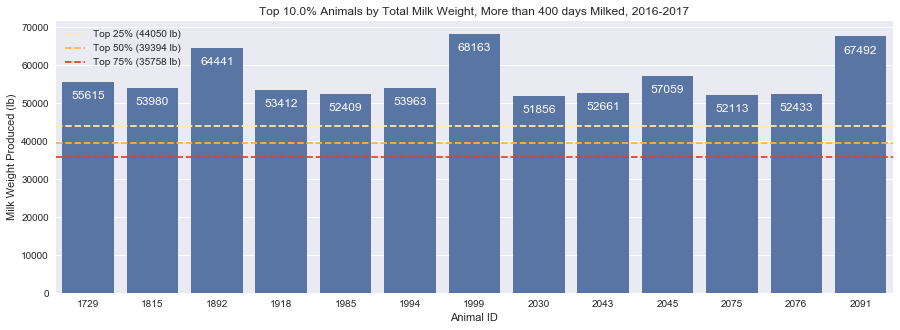

,Animal ID,Birthdate,Days Milked,Per Day Average,Total Milk-Pounds
96,2075,2013-11-17,638,81.68,52113.2
108,1994,2012-11-22,636,84.85,53963.3
110,2076,2013-11-30,615,85.26,52433.0
112,2043,2013-06-26,614,85.77,52661.8
113,1985,2012-09-27,611,85.78,52409.8
114,1815,2010-12-02,628,85.96,53980.3
115,2030,2013-05-08,592,87.60,51856.6
119,2045,2013-07-03,635,89.86,57059.9
120,1918,2011-12-12,585,91.30,53412.1
123,1729,2009-12-05,567,98.09,55615.7


In [59]:
def plot_top_performers(performance_profiles, top_percentage=0.10):
    target_quantile = 1 - top_percentage
    target_milk = performance_profiles['Total Milk-Pounds'].quantile(target_quantile)
    data = performance_profiles[performance_profiles['Total Milk-Pounds'] > target_milk]
    
    fig, ax = plt.subplots(figsize=(15, 5))
    
    ax = sns.barplot(ax=ax, y='Total Milk-Pounds', x='Animal ID', data=data, palette=sns.color_palette(n_colors=1))
    _ = plt.xlabel('Animal ID')
    _ = plt.ylabel('Milk Weight Produced (lb)')
    
    percentile = top_percentage * 100
    _ = plt.title(f'Top {percentile}% Animals by Total Milk Weight, More than 400 days Milked, 2016-2017')
    
    top_quarter = performance_profiles['Total Milk-Pounds'].quantile(0.75)
    line_25 = ax.axhline(top_quarter, ls='--', c='#ffeda0', label='Top 25%')
    
    top_half = performance_profiles['Total Milk-Pounds'].quantile(0.50)
    line_50 = ax.axhline(top_half, ls='--', c='#feb24c', label='Top 50%')
    
    top_three_quarters = performance_profiles['Total Milk-Pounds'].quantile(0.25)
    line_75 = ax.axhline(top_three_quarters, ls='--', c='#f03b20', label='Top 75%')
    
    plt.legend([line_25, line_50, line_75], 
               [f'Top 25% ({int(top_quarter)} lb)',
                f'Top 50% ({int(top_half)} lb)',
                f'Top 75% ({int(top_three_quarters)} lb)'], 
               loc='best')
    
    ax = plt.gca()
    for p in ax.patches:
        _ = ax.text(p.get_x() + p.get_width()/2., 
                    p.get_height() - 5000, 
                    '%d' % int(p.get_height()), 
                    fontsize=12, color='white', ha='center', va='bottom')
    return data

top_ten_percent = plot_top_performers(performance_profiles, top_percentage=0.1)
plt.savefig('figures/top_producers.png', dpi=300, bbox_inches='tight')
plt.show()
top_ten_percent

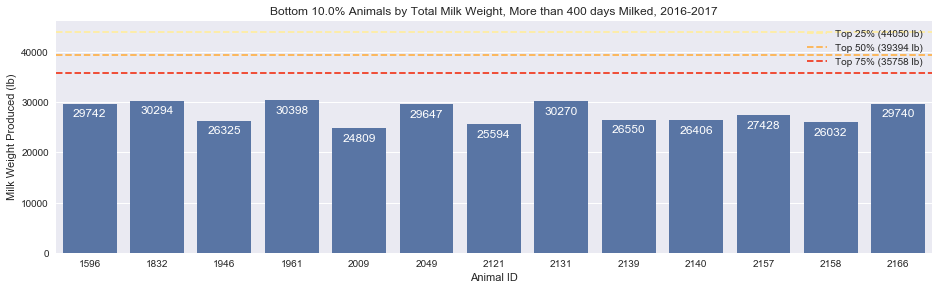

,Animal ID,Birthdate,Days Milked,Per Day Average,Total Milk-Pounds
0,2009,2013-01-19,432,57.43,24809.6
1,2139,2014-08-10,454,58.48,26550.9
2,2140,2014-08-15,447,59.08,26406.7
3,2121,2014-05-21,423,60.51,25594.3
4,2158,2014-09-29,422,61.69,26032.6
6,1961,2012-06-25,491,61.91,30398.7
7,2157,2014-09-28,438,62.62,27428.6
14,2131,2014-07-10,464,65.24,30270.3
15,1946,2012-05-24,402,65.49,26325.7
18,1832,2011-02-23,454,66.73,30294.3


In [51]:
def plot_bottom_performers(performance_profiles, bottom_percentage=0.10):
    target_milk = performance_profiles['Total Milk-Pounds'].quantile(bottom_percentage)
    data = performance_profiles[performance_profiles['Total Milk-Pounds'] < target_milk]
    
    a4_dims = (15.7, 4.27)
    fig, ax = plt.subplots(figsize=a4_dims)
    
    ax = sns.barplot(ax=ax, y='Total Milk-Pounds', x='Animal ID', data=data, palette=sns.color_palette(n_colors=1))
    _ = plt.xlabel('Animal ID')
    _ = plt.ylabel('Milk Weight Produced (lb)')
    
    percentile = bottom_percentage * 100
    _ = plt.title(f'Bottom {percentile}% Animals by Total Milk Weight, More than 400 days Milked, 2016-2017')
    
    top_quarter = performance_profiles['Total Milk-Pounds'].quantile(0.75)
    line_25 = ax.axhline(top_quarter, ls='--', c='#ffeda0', label='Top 25%')
    
    top_half = performance_profiles['Total Milk-Pounds'].quantile(0.50)
    line_50 = ax.axhline(top_half, ls='--', c='#feb24c', label='Top 50%')
    
    top_three_quarters = performance_profiles['Total Milk-Pounds'].quantile(0.25)
    line_75 = ax.axhline(top_three_quarters, ls='--', c='#f03b20', label='Top 75%')
    
    plt.legend([line_25, line_50, line_75], 
               [f'Top 25% ({int(top_quarter)} lb)',
                f'Top 50% ({int(top_half)} lb)',
                f'Top 75% ({int(top_three_quarters)} lb)'], 
               loc='best')
    
    ax = plt.gca()
    for p in ax.patches:
        _ = ax.text(p.get_x() + p.get_width()/2., 
                    p.get_height() - 3000, 
                    '%d' % int(p.get_height()), 
                    fontsize=12, color='white', ha='center', va='bottom')
    return data

bottom_ten_percent = plot_bottom_performers(performance_profiles, bottom_percentage=0.1)
plt.savefig('figures/bottom_producers.png', dpi=300, bbox_inches='tight')
plt.show()
bottom_ten_percent